In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
from Preprocessing.labeling import resample_close, get_t1, get_events, get_lookback_vol
from Research.fx_utils import fx_data_import, bbg_data_import, macro_data_import
from Research.FXTesting import pca_distance_loop, get_nonusd_pair_data, get_nonusd_pairs, get_nonusd_close
from Preprocessing.sampling import _get_num_concurrent_events, _get_average_uniqueness
from Preprocessing.etf_trick import ETFTrick
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl
from Modelling.cross_val import PurgedKFold


home_machine = True
gen_tricks = False
start_date = dt.datetime(2000,1,1)
lookback = 500
# implement citi reversion



if home_machine:
    close = fx_data_import()
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes = get_nonusd_close(close, nonusd_pairs)
    tr_df = pair_closes.dropna(how='any')
else:
    close, yields = bbg_data_import(vs_dollar=True)
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes, cross_yields = get_nonusd_pair_data(close, yields, nonusd_pairs)
    cross_yields = cross_yields.fillna(0)/100./365.

if not gen_tricks:
    close = close.loc[start_date:]
    pair_closes = pair_closes.loc[start_date:]

#   if we wanted to drop the union of NAs
#    cross_yields = crosses.merge(yields, left_index=True, right_index=True, suffixes=('_px','_yld'))

# generate the indicator matrix whether pair is within cluster_threshold based on pca distances
group_matrix = pca_distance_loop(close, lookback, 4, 0.1, nonusd_pairs, components_to_use=[1,2,3])

# generate x-sigma signals
zscores = lookback_zscore(pair_closes, 30, lookback)
signals = zscore_signal(zscores, 2, 'Reversion')

# only take signals where the pair is 'grouped' at the time
group_signals = signals.multiply(group_matrix.loc[signals.index[0]:])
events_d = {}
tricks = []
if not gen_tricks:
    norm_srs = pd.read_excel(r"C:\Users\Brendan\FinML\MLFin\raw_data\nocarrytrickdata.xlsx", index_col=0)
    norm_srs = norm_srs.loc[start_date:]

for pair in nonusd_pairs:
    # skip if theres no group
    if (len(group_signals[pair][abs(group_signals[pair])>0]) == 0) or pair not in norm_srs.columns:
        continue
    
    print(pair, dt.datetime.now())
    
    weights = pd.DataFrame(np.ones(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
    
    # ETF trick on one pair
    # check if we're using yields
    if gen_tricks:
        if home_machine:
            carry = pd.DataFrame(np.zeros(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, carry)

        else:
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, cross_yields)
        tr_s = tr.get_etf_series()
        tricks.append(tr_s)
    else:
        tr_s = norm_srs.loc[:,pair]
        
    events0 = zscore_sizing(group_signals[pair], pair_closes[pair], 400, 50, lookback, pt_sl=(1,4))
    if events0 is None:
        continue
    events = generate_pnl(events0, tr_s)
    events_d[pair] = events



BRLCAD 2020-02-23 18:53:16.627299
BRLMXN 2020-02-23 18:53:16.805376
BRLZAR 2020-02-23 18:53:17.148439
BRLAUD 2020-02-23 18:53:17.439334
BRLNZD 2020-02-23 18:53:17.614252
CADMXN 2020-02-23 18:53:17.751160
CADNOK 2020-02-23 18:53:17.950057
CADSEK 2020-02-23 18:53:18.077988
CADZAR 2020-02-23 18:53:18.202949
CADAUD 2020-02-23 18:53:18.355853
CADNZD 2020-02-23 18:53:18.572737
CNYSLR 2020-02-23 18:53:18.758895
DKKNOK 2020-02-23 18:53:18.992771
DKKSEK 2020-02-23 18:53:19.523508
DKKCHF 2020-02-23 18:53:19.971307
DKKEUR 2020-02-23 18:53:20.161234
DKKGBP 2020-02-23 18:53:20.979108
HKDTHB 2020-02-23 18:53:21.537467
INRKRW 2020-02-23 18:53:21.661456
INRTWD 2020-02-23 18:53:21.883346
JPYSGD 2020-02-23 18:53:22.087542
JPYGBP 2020-02-23 18:53:22.264452
KRWTWD 2020-02-23 18:53:22.563347
KRWTHB 2020-02-23 18:53:23.176634
MXNZAR 2020-02-23 18:53:23.208629
NOKSEK 2020-02-23 18:53:23.495639
NOKCHF 2020-02-23 18:53:24.124369
NOKEUR 2020-02-23 18:53:24.266301
NOKGBP 2020-02-23 18:53:24.790145
SEKCHF 2020-02

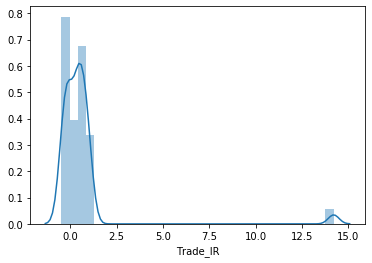

In [2]:
import seaborn as sns
cumul_pnl = pd.Series([e['ret'].sum() for key,e in events_d.items()], index=events_d.keys())
std_pnl = pd.Series([e['ret'].std() for key,e in events_d.items()], index=events_d.keys())
avg_pnl = pd.Series([e['ret'].mean() for key,e in events_d.items()], index=events_d.keys())
num_bets = pd.Series([e.shape[0] for key,e in events_d.items()], index=events_d.keys())
hit_ratio = pd.Series([e[e['ret']>0].loc[:,'ret'].count() for key,e in events_d.items()], index=events_d.keys())
pnl_df = pd.concat([cumul_pnl, std_pnl, avg_pnl, num_bets, hit_ratio/num_bets], axis=1, keys=['cumul','std','mean','num_bets','hit_ratio'])

# trade_ir not to be confused with strategy ir
# todo: method to generate daily mark to market
pnl_df['Trade_IR'] = pnl_df['mean']/pnl_df['std']
sns.distplot(pnl_df['Trade_IR'].dropna())

In [3]:
# lets put together some features
macro_data = macro_data_import().drop('PALLFNFINDEXM',axis=1)
macro_data = macro_data.rename({'Close':'VIX','PALLFNFINDEXM':'CommodIdx', 'DGS3MO': '3M_Bill','DFII10':'10Y_RY'}, axis=1)
macro_data = macro_data.replace(0, np.nan)
macro_data = macro_data.fillna(method='ffill')

# standardize
window = 125
macro_standard = macro_data.subtract(macro_data.rolling(window).mean())
macro_standard = macro_standard.divide(macro_standard.rolling(window).std())

macro_standard = macro_standard.loc[start_date:]
macro_standard.fillna(0, inplace=True)
macro_standard.tail()

,VIX,BAA10Y,3M_Bill,10Y_RY
2020-02-10,0.181924,-0.878182,-0.941054,-1.524607
2020-02-11,0.247676,-1.001162,-0.990903,-1.234641
2020-02-12,-0.357985,-0.845168,-0.849502,-1.111241
2020-02-13,-0.162662,-0.970731,-0.709327,-1.300146
2020-02-14,-0.359767,-0.954287,-0.668417,-1.347862


In [4]:
# let's train a forest on AUDNZD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import log_loss
from Preprocessing.sampling import _get_average_uniqueness, get_sample_weight
from Modelling.feature_importance import aux_feat_imp_sfi, feat_imp_mda
from Preprocessing.labeling import get_bins

pair = 'AUDNZD'

events = events_d[pair]
b = get_bins(events, norm_srs.loc[:, pair])
w = get_sample_weight(events['t1'], norm_srs.loc[:, pair])
events['bin'] = b.loc[:, 'bin']
events['w'] = w
conc = _get_num_concurrent_events(norm_srs.index, events['t1'])
avg_uniq = _get_average_uniqueness(events['t1'], conc).mean()

clf = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
bc = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_samples=avg_uniq, max_features=1.)

# reindex macro_standard to events starts
macro_standard = macro_standard.reindex(events.index)
imp = aux_feat_imp_sfi(macro_standard.columns, bc, macro_standard, events, 'neg_log_loss', 5)
imp


C:\Users\Brendan\FinML\MLFin\Preprocessing\sampling.py:196: RuntimeWarning: invalid value encountered in true_divide
  wgt = np.nansum(live_rets/num_conc_events[:, None].T, axis=1) # mx1


,mean,std
VIX,-0.831351,0.103406
BAA10Y,-0.899323,0.199188
3M_Bill,-0.980999,0.249163
10Y_RY,-0.699284,0.120602


In [5]:
# mean decrease accuracy
imp_mda = feat_imp_mda(bc, macro_standard, events, scoring='accuracy', n_splits=5, pct_embargo=0.01)
imp_mda

(             mean       std
 VIX     -0.019973  0.019973
 BAA10Y  -0.032598  0.022253
 3M_Bill -0.058590  0.037445
 10Y_RY  -0.227029  0.209123, 0.5830673950805499)